# Pré-processamento e visualização preliminar

Este notebook é utilizado tanto para visualização quanto pré-processamento dos dados de entrada.

## Imports e configurações iniciais

In [2]:
# Se necessário (usando kernel conda_amazonei_tensorflow2_p36 do Sagemaker)
%pip install wordcloud
%pip install stanza

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 435 kB 28.9 MB/s            
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 691 kB 28.6 MB/s            
     |████████████████████████████████| 240 kB 98.7 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 881.9 MB 7.6 kB/s              
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234906 sha256=96a6280d3cc02bb191344e6113748e73f28ce3de624735c83b34c75f746b2900
  Stored in directory: /home/ec2-user/.cache/pip/wheels/20/ae/c3/a0104b9bcd7396b30ea031e758ff74ab197e63f203e895ad69
Successfully built emoji
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from python_scripts.save_load import load_df_from_bucket, save_df_to_s3_bucket
from python_scripts.plots import plot_cloud
from python_scripts.processing import create_tokenized_df

## Dataset 1: Fake.br-Corpus
Este é um dataset de notícias reais e falsas datado em 2018.
O repositório do dataset no GitHub (https://github.com/roneysco/Fake.br-Corpus) disponibiliza as notícias tanto em formato cru (apenas texto, sem processar), quanto em um formato pré-processado, como arquivo .csv. Para o desenvolvimento do presente projeto, optou-se pela utilização dos dados crus, para fins didáticos de executar o processamento durante o projeto. 

A primeira parte do pré-processamento consistiu em unificar todos os arquivos .txt das notícias brutas em único arquivo .csv. Isto foi feito no notebook `prepare_csv.ipynb`. O arquivo .csv obtido possui apenas 2 colunas:
- fake: 1 se a notícia for Falsa, 0 se a notícia for real
- text: o texto da notícia

A segunda etapa de pré-processamento é o processamento dos textos em si. Esta etapa inclui a remoção de stopwords e sinais de pontuação. A biblioteca Stanza também foi utilizada para executar a lematização dos textos, substituindo as palavras por seus lemas correspondentes.

In [3]:
file_name = 'dados_brutos.csv'
raw_corpusbr = load_df_from_bucket(file_name, tipo='bruto')
raw_corpusbr.head()

,fake,text
0,0,A divisão do STF ao meio entre partidários e ...
1,1,"General manda recado para STF: ""Abaixaram as c..."
2,1,O Nordeste acordou! Lula e o PT são enxotados:...
3,0,"Dois relatórios da Polícia Federal, com análi..."
4,1,Coreia do Norte declara status de QUASE-GUERRA...


## Visualização preliminar
Rápida visualização de nuvem de palavras do Dataset

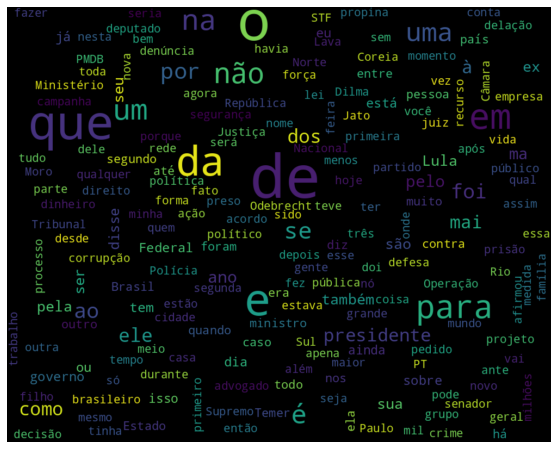

In [4]:
plot_cloud(' '.join([x for x in raw_corpusbr['text']]))

Como os dados ainda não foram limpos, nota-se de imediato a presença de muitas stopwords (da, de, que, uma, em, etc.). Porém, dentre as outras palavras presentes, nota-se que este dataset aparenta conter muitas notícias relacionadas a política. Vemos muitas palavras relacioandas a assuntos políticos, como direito, trabalho, Operação, advogado, STF, Supremo, Tribunal, presidente, governo, Federal, Polícia, nomes de políticos, etc.

### Lemmatização do DataFrame
Definição da função create_tokenized_df em python_scripts/processing.py

In [5]:
processed_corpusbr = create_tokenized_df(raw_corpusbr, remove_nao=False)

Processando linhas 0 a 499...
Processando linhas 500 a 999...
Processando linhas 1000 a 1499...
Processando linhas 1500 a 1999...
Processando linhas 2000 a 2499...
Processando linhas 2500 a 2999...
Processando linhas 3000 a 3499...
Processando linhas 3500 a 3999...
Processando linhas 4000 a 4499...
Processando linhas 4500 a 4999...
Processando linhas 5000 a 5499...
Processando linhas 5500 a 5999...
Processando linhas 6000 a 6499...
Processando linhas 6500 a 6999...
Processando linhas 7000 a 7499...


In [6]:
processed_corpusbr['words_str'] = processed_corpusbr['words'].apply(lambda x: ' '.join(x))
processed_corpusbr['lemmas_str'] = processed_corpusbr['lemmas'].apply(lambda x: ' '.join(x))

In [7]:
processed_corpusbr.head()

,fake,text,words,lemmas,avg_sent_len,avg_word_len,words_str,lemmas_str
0,0,A divisão do STF ao meio entre partidários e ...,"[divisão, STF, meio, partidários, independente...","[divisão, STF, meio, partidário, independente,...",10.504673,6.785107,divisão STF meio partidários independentes fic...,divisão STF meio partidário independente ficar...
1,1,"General manda recado para STF: ""Abaixaram as c...","[General, manda, recado, STF, Abaixaram, calça...","[general, mandar, recado, STF, abaixar, calça,...",10.866667,6.502610,General manda recado STF Abaixaram calças Cong...,general mandar recado STF abaixar calça congre...
2,1,O Nordeste acordou! Lula e o PT são enxotados:...,"[Nordeste, acordou, Lula, PT, enxotados, Chega...","[nordeste, acordar, Lula, PT, enxotar, chegar,...",7.333333,6.565873,Nordeste acordou Lula PT enxotados Chega bande...,nordeste acordar Lula PT enxotar chegar bandei...
3,0,"Dois relatórios da Polícia Federal, com análi...","[Dois, relatórios, Polícia, Federal, análises,...","[dois, relatório, Polícia, Federal, análise, m...",16.878788,7.286668,Dois relatórios Polícia Federal análises mater...,dois relatório Polícia Federal análise materia...
4,1,Coreia do Norte declara status de QUASE-GUERRA...,"[Coreia, Norte, declara, status, QUASE-GUERRA,...","[Coreia, Norte, declarar, status, QUASE-GUERRA...",11.600000,6.531320,Coreia Norte declara status QUASE-GUERRA mobil...,Coreia Norte declarar status QUASE-GUERRA mobi...


### Salvar dados processados no S3

In [71]:
processed_file = 'dados_processados.csv'
processed_bucket = 'projetointerdisciplinardadosprocessados'

# Salvar tudo no S3 (armazenamento não é problema)
processed_corpusbr.to_csv(f's3://{processed_bucket}/{processed_file}', encoding='utf-8', index=False)


In [72]:
# Remover colunas de listas antes de salvar local, economizar espaço (GitHub aceita só até 100 MB)
for column_name in ['words', 'lemmas']:
    if column_name in processed_corpusbr.columns:
        processed_corpusbr = processed_corpusbr.drop(column_name, axis=1)

processed_corpusbr.to_csv(processed_file, encoding='utf-8', index=False)

## Dataset 2: FakeRecogna
Este dataset possui notícias do período de 2019 a 2021. O repositório do Dataset no GitHub (https://github.com/Gabriel-Lino-Garcia/FakeRecogna) apresenta os dados já tabelados em arquivos .xlsx, disponíveis em dois formatos, sendo um chamado de "no_removal_words" no repositório, sugerindo neste não foi feita a remoção de stopwords, e portanto, que estas foram removidas no outro arquivo. Aqui, optou-se pela utilização do Dataset já processado, para simplicidade.

Os arquivos xlsx deste dataset contém também mais dados das notícias, como sua data, título, subtítulo, corpo da notícia propriamente dita, fonte, autor, categoria (assunto) e classe (verdadeira ou falsa). Neste dataset, utilizou-se o inverso do padrão utilizado no projeto para a coluna alvo, ou seja, aqui 0 sinalize uma notícia Falsa e 1 sinaliza uma notícia real; esta inconsistência será tratada no processamento feito a seguir. O projeto irá focar primariamente no texto da notícia e na sua classificação, para facilitar a comparação com o outro dataset que não apresenta a mesma riqueza de dados.

In [9]:
dset_link = 'https://github.com/Gabriel-Lino-Garcia/FakeRecogna/raw/master/dataset/FakeRecogna.xlsx'
raw_recogna =  pd.read_excel(dset_link, engine='openpyxl')  # engine para xlsx
raw_recogna.head()

,Titulo,Subtitulo,Noticia,Categoria,Data,Autor,URL,Classe
0,\n\nPapa Francisco foi preso sob acusação de t...,Boato – Ocorreu um apagão no Vaticano. O papa ...,apagão vaticano papar presar acusação tráfico ...,entretenimento,11/01/2021,\nEdgard Matsuki,https://www.boatos.org/religiao/papa-francisco...,0.0
1,Equador prepara cova coletiva para mortos por ...,NaN,o governar equador anunciar preparar cova cole...,saúde,27/03/2020 18h25,27/03/2020 18h25,https://noticias.uol.com.br/internacional/ulti...,1.0
2,Air France voltará a operar voo direto Pequim-...,NaN,o companhia air france operar voar direto pequ...,saúde,07/08/2020 13h42,07/08/2020 13h42,https://www.uol.com.br/nossa/noticias/afp/2020...,1.0
3,Marfrig intensifica venda de carne do Brasil a...,NaN,o marfrig global foods retomar vender carnar b...,saúde,27/04/2020 14h53,27/04/2020 14h53,https://economia.uol.com.br/noticias/reuters/2...,1.0
4,As parciais das eleições de 2014 alternaram ma...,NaN,o assunto voltar o compartilhar rede social ju...,entretenimento,31/07/2021,Gilmar Lopes,https://www.e-farsas.com/as-parciais-das-eleic...,0.0


In [10]:
raw_recogna.shape

(11903, 8)

Aqui, notam-se alguns pontos interessantes do DataFrame com uma rápida insperação:
- Há dados faltantes, pelo menos na coluna de subtítulo. Necessário investigar mais a fundo.
- Coluna de autor apresenta erros, muitas vezes a data da notícia vem como autor
- Texto da notícia aparenta já vir em formato lematizado, pela seleção de palavras.

Como a análise será focada na coluna de texto e classe da notícia, problemas em outras colunas não são relevantes para o projeto. Porém, é necessário investigar a presença de nulos.

In [11]:
raw_recogna.isna().sum()

Titulo         31
Subtitulo    6323
Noticia         1
Categoria       1
Data          352
Autor          17
URL             1
Classe          1
dtype: int64

In [12]:
raw_recogna[raw_recogna['Noticia'].isna()]

,Titulo,Subtitulo,Noticia,Categoria,Data,Autor,URL,Classe
7337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Há uma linha sem Notícia onde todos os valores são nulos. Esta linha correspondente também à linha onde a informação de classe e categoria são nulas. Esta linha será eliminada.

In [13]:
raw_recogna.dropna(subset=['Noticia'], inplace=True)

## Visualização preliminar
Rápida visualização de nuvem de palavras do Dataset

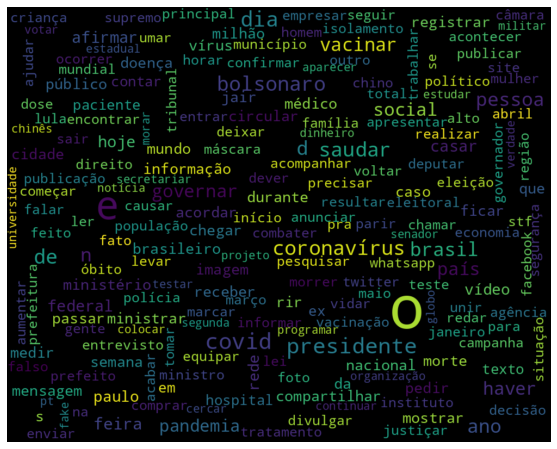

In [14]:
plot_cloud(' '.join([x for x in raw_recogna['Noticia']]))

Neste dataset, nota-se uma presença de maior variedade de assuntos. O próprio Github onde o dataset está hospedado traz esta informação, listando assuntos como não apenas política (foco do dataset anterior), mas também saúde e, em menor escala, entretenimento, ciência, notícias mundiais e notícias gerais do Brasil. Em particular, como o dataset traz muitas notícias do período de 2020 a 2021, nota-se a presença de muitas palavras referentes à pandemia de coronavírus, como covid, coronavírus e vacinar.

Nota-se também que, apesar da aparente remoção destopwords, algumas sobrevivem no dataset, como "o", "e" e alguns aparentes erros, como "d", "s" e "n". Estas palavras serão removidas durante o processamento.

## Processamento
Remoção de palavras anômalas listadas anteriormente. Serão mantidas apenas três colunas do Dataset: o texto da notícia, a classificação (real/falsa) e a categoria, que eventualmente poderá ser utilizada em análises futuras. Para facilitar a comparação entre datasets, os nomes de colunas utilizados seguirão o padrão utilizado no DataFrame processado do dataset Fake.br-Corpus, ou seja:

- lemma_str: coluna com texto da notícia lematizado
- fake: 1 para notícia falsa, 0 para notícia real

Adicionado da coluna de categoria para eventuais análises feitas apenas neste dataset

In [23]:
import nltk
nltk.download('all', quiet=True)

True

In [58]:
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords.extend(['s','d','n', '“', '”'])

In [59]:
processed_recogna = raw_recogna[['Classe', 'Noticia', 'Categoria']].copy()
processed_recogna.head()

,Classe,Noticia,Categoria
0,0.0,apagão vaticano papar presar acusação tráfico ...,entretenimento
1,1.0,o governar equador anunciar preparar cova cole...,saúde
2,1.0,o companhia air france operar voar direto pequ...,saúde
3,1.0,o marfrig global foods retomar vender carnar b...,saúde
4,0.0,o assunto voltar o compartilhar rede social ju...,entretenimento


In [60]:
import string
processed_recogna['lemmas_str'] =  [' '.join([y for y in x.split() if y not in stopwords]) 
                                   for x in raw_recogna['Noticia']]
# Remover pontuação
processed_recogna['lemmas_str'] = processed_recogna['lemmas_str'].str.replace('[{}]'.format(string.punctuation), '')
processed_recogna.head()

,Classe,Noticia,Categoria,lemmas_str
0,0.0,apagão vaticano papar presar acusação tráfico ...,entretenimento,apagão vaticano papar presar acusação tráfico ...
1,1.0,o governar equador anunciar preparar cova cole...,saúde,governar equador anunciar preparar cova coleti...
2,1.0,o companhia air france operar voar direto pequ...,saúde,companhia air france operar voar direto pequim...
3,1.0,o marfrig global foods retomar vender carnar b...,saúde,marfrig global foods retomar vender carnar bov...
4,0.0,o assunto voltar o compartilhar rede social ju...,entretenimento,assunto voltar compartilhar rede social julho ...


In [61]:
processed_recogna['fake'] = (~processed_recogna['Classe'].astype(bool)).astype(int) # inverter 1 e 0
processed_recogna.head()

,Classe,Noticia,Categoria,lemmas_str,fake
0,0.0,apagão vaticano papar presar acusação tráfico ...,entretenimento,apagão vaticano papar presar acusação tráfico ...,1
1,1.0,o governar equador anunciar preparar cova cole...,saúde,governar equador anunciar preparar cova coleti...,0
2,1.0,o companhia air france operar voar direto pequ...,saúde,companhia air france operar voar direto pequim...,0
3,1.0,o marfrig global foods retomar vender carnar b...,saúde,marfrig global foods retomar vender carnar bov...,0
4,0.0,o assunto voltar o compartilhar rede social ju...,entretenimento,assunto voltar compartilhar rede social julho ...,1


In [62]:
processed_recogna.drop(['Classe', 'Noticia'], axis=1, inplace=True)
processed_recogna.head()

,Categoria,lemmas_str,fake
0,entretenimento,apagão vaticano papar presar acusação tráfico ...,1
1,saúde,governar equador anunciar preparar cova coleti...,0
2,saúde,companhia air france operar voar direto pequim...,0
3,saúde,marfrig global foods retomar vender carnar bov...,0
4,entretenimento,assunto voltar compartilhar rede social julho ...,1


### Salvar dados processados no S3

In [73]:
processed_file = 'dados_processados_recogna.csv'
processed_bucket = 'projetointerdisciplinardadosprocessados'

# Salvar tudo no S3 (armazenamento não é problema)
processed_recogna.to_csv(f's3://{processed_bucket}/{processed_file}', encoding='utf-8', index=False)


In [74]:
# Salvar local para github
processed_recogna.to_csv(processed_file, encoding='utf-8', index=False)

## Dataset 3: Dataset combinado
Unificar os dois datasets em um único dataset com todas as notícias

In [4]:
# Carregar do S3 se necessário (caso apenas esta parte do Notebook seja executada)
processed_fakebr = load_df_from_bucket('dados_processados.csv', tipo='processado')
processed_recogna = load_df_from_bucket('dados_processados_recogna.csv', tipo='processado')

In [8]:
# Manter apenas colunas lemmas_str e fake, comuns a ambos dataframes
columns_to_keep = ['fake', 'lemmas_str']
processed_fakebr = processed_fakebr[columns_to_keep]
processed_recogna = processed_recogna[columns_to_keep]

In [9]:
combined_df = pd.concat([processed_fakebr, processed_recogna])

### Salvar dados processados no S3

In [17]:
processed_file = 'dados_processados_combinados.csv'
processed_bucket = 'projetointerdisciplinardadosprocessados'

# Salvar tudo no S3 (armazenamento não é problema)
combined_df.to_csv(f's3://{processed_bucket}/{processed_file}', encoding='utf-8', index=False)

In [18]:
# Salvar local para github
combined_df.to_csv(processed_file, encoding='utf-8', index=False)